# Project name: AI-driven demand forecasting 

## [Section1]

## Student names (listed alphabetically):

- Vasileios Geroulas (vgeroula)
- Vasiliki Tsianika (vtsian)

## Main Sections of this Project
There are 2 main sections comprising this project, each with a separate Notebook:
1. __Data Preparation and Feature Creation.__ In this section we focus on data import, data manipulation and feature engineering. 
2. __Analytics and ML Modeling.__ In this section we focus on analyzing the features extracted in Section 1, to provide forecasts of demand. 

## Section 1: Data Preparation and Feature Creation

In this section we will import the data, perform any data manipulation needed, and we will extract features that will be used in building the time series analytics and ML supervised (regression) models in the Section 2. Comments are added throughout the notebook to explain the process.

### Notes for the Script to Run
- The data files (CSV) are expected to be stored in a folder called "__Data__", which resides in the same directory as the Python script.

### Python Modules

Import all the required Python modules.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

### Load Data

Load the data from the downloaded CSV files into Pandas Dataframes.
The CSV files can be downloaded from the link below:
https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data

In [2]:
# Load CSV data files

item_cats  = pd.read_csv(r'./Data/item_categories.csv')
items = pd.read_csv(r'./Data/items.csv')
shops = pd.read_csv(r'./Data/shops.csv')
sales_train = pd.read_csv(r'./Data/sales_train.csv')
sales_test  = pd.read_csv(r'./Data/test.csv')

Get a glimpse of the data, by printing the first 2 rows of each table.

In [3]:
item_cats.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [4]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [5]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [6]:
sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [7]:
sales_test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


### Data Preparation 1 - Text Data

The "__item_name__", "__shop_name__" and "__item_category_name__" features of the data are texts written based on the Cyrillic alphabet. These texts are not crucial for our analysis, as we will be using the respective id's instead. However, we will replace them with dummy but readable data, so the text in the visualizations we will create later is readable by the users.

Moreover, based on the data description we found online, we should consider the following:
- The "__shop_name__" always starts with the __city name__. It is followed by a space " ".
- The "__item_category_name__" always starts with a __type description__ . It is followed by a dash "-".

In [8]:
# Extract the city from "shop_name". Then create a unique "city_id" for each city.
shops['city_name'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_id'] = LabelEncoder().fit_transform(shops['city_name'])
shops.head()

# Extract the type from "item_category_name". Then create a unique "type_id" for each category.
item_cats['type_name'] = item_cats['item_category_name'].str.split('-').map(lambda x: x[0].strip())
item_cats['type_id'] = LabelEncoder().fit_transform(item_cats['type_name'])

# Replace remaining text with dummy names
for i in range(len(items)):
    items.iloc[i,0] = 'Item ' + str(i)

for i in range(len(shops)):
    shops.iloc[i,0] = 'Shop ' + str(i)
shops['city_name'] = shops.city_id.map(lambda x: 'City '+str(x))

for i in range(len(item_cats)):
    item_cats.iloc[i,0] = 'Item Category ' + str(i)
item_cats['type_name'] = item_cats.type_id.map(lambda x: 'Type '+str(x))

### Data Exploration 1

This is the first part of data exploration, and will help us to better understand the data (and to later merge all the dataframes into a single one).

In [9]:
# Number of unique item categories
item_cats_num = len(item_cats)
print('Number of unique item categories: ',item_cats_num)

# Number of unique item types
item_types_num = len(item_cats.type_id.unique())
print('Number of unique item types: ',item_types_num)

# Number of unique items
items_num = len(items)
print('Number of unique items: ',items_num)

# Number of shops
shops_num = len(shops)
print('Number of shops: ',shops_num)

# Number of cities
cities_num = len(shops.city_id.unique())
print('Number of cities: ',cities_num)

# Number of database records
data_records_num = len(sales_train)
print('Number of data records: ',data_records_num)

# Number of months
months_num = len(sales_train.date_block_num.unique())
print('Number of months: ',months_num)

# Date of oldest record and newest record
dates_in_dt_format = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
oldest_date = dates_in_dt_format.min()
print('Oldest date: ',oldest_date)
newest_date = dates_in_dt_format.max()
print('Newest date: ',newest_date)

# Range of prices
lowest_price = sales_train.item_price.min()
highest_price = sales_train.item_price.max()
print('Items price range: ', lowest_price, '-', highest_price)

# Range of units sold
lowest_num_units = sales_train.item_cnt_day.min()
highest_num_units = sales_train.item_cnt_day.max()
print('Number of units sold range: ', lowest_num_units, '-', highest_num_units)

Number of unique item categories:  84
Number of unique item types:  20
Number of unique items:  22170
Number of shops:  60
Number of cities:  32
Number of data records:  2935849
Number of months:  34
Oldest date:  2013-01-01 00:00:00
Newest date:  2015-10-31 00:00:00
Items price range:  -1.0 - 307980.0
Number of units sold range:  -22.0 - 2169.0


We will now create some plots to get even more details about the data.

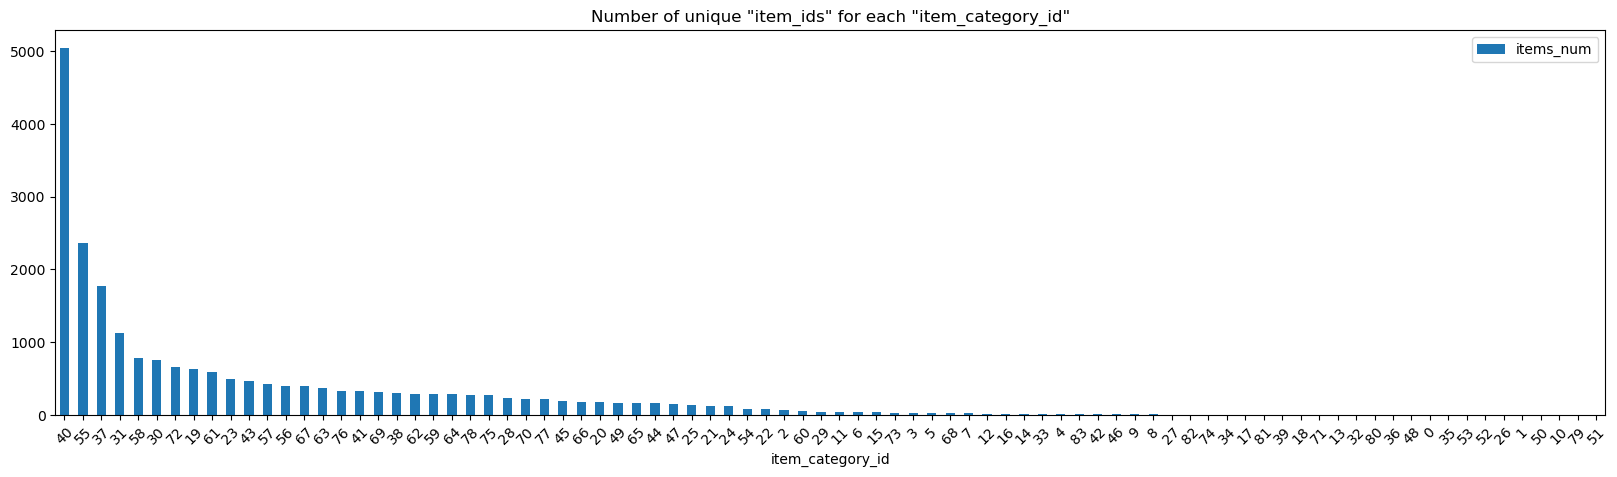

In [10]:
# Create a plot to see the distribution of items among the different item categories

temp_df = item_cats['item_category_id'].to_frame()

temp_df2 = items['item_category_id'].value_counts().to_frame()
temp_df2.columns = ['items_num']

temp_df = temp_df.merge(temp_df2, left_on='item_category_id', right_index=True).sort_values(by='items_num', ascending=False)

ax = temp_df.plot.bar(x='item_category_id', y='items_num', rot=45, figsize=(20,5), 
                      title='Number of unique "item_ids" for each "item_category_id"')

__What we observe in the plot (bar chart) above:__  
- The data is not uniformly distributed. Some item categories contain numerous item ids, while some others contain very few.
- From the total of 84 item categories, only 4 contain more than 1000 item id's.  
- There are 11 item categories that contain very few (<=5) item id's.

C:\Users\SESA671988\AppData\Local\Temp\ipykernel_7180\2278806110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['revenue'] = temp_df['item_cnt_day'] * temp_df['item_price']


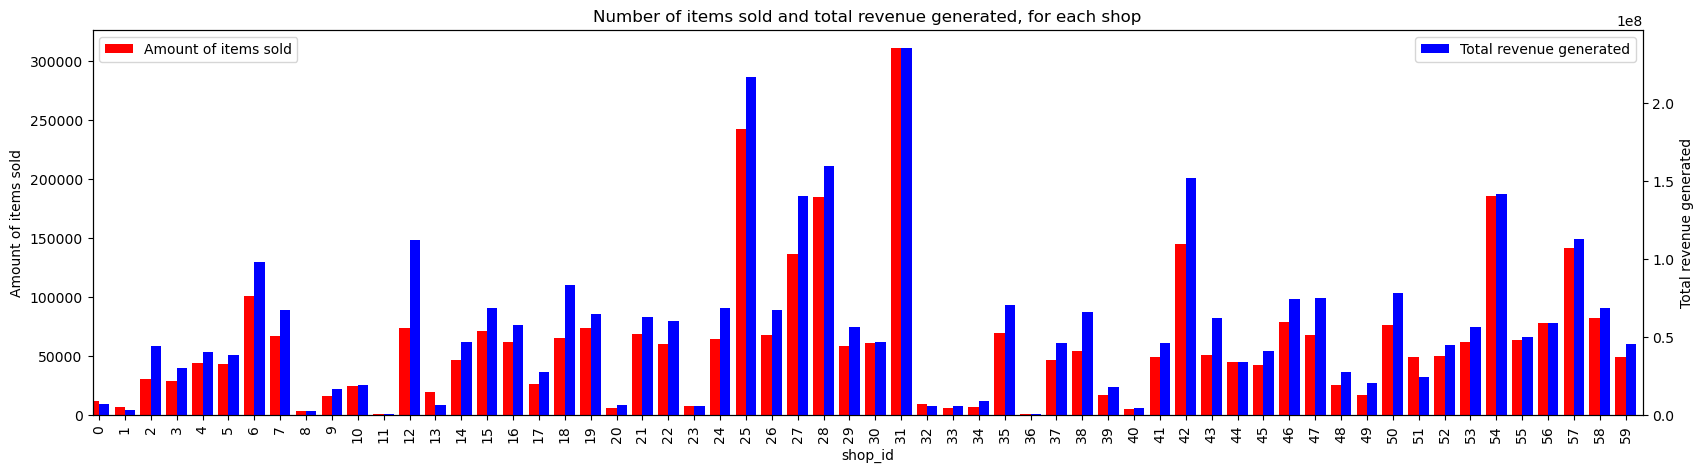

In [11]:
# Create a plot to see how many items (of any item_id) each shop has sold, along with the total revenue generated

temp_df = sales_train[['shop_id','item_cnt_day','item_price']]
temp_df['revenue'] = temp_df['item_cnt_day'] * temp_df['item_price']

temp_df = temp_df.groupby('shop_id').agg({'item_cnt_day':sum, 'revenue':sum})
temp_df.reset_index(inplace=True)

fig = plt.figure(figsize=(20,5))  #Create matplotlib figure

ax = fig.add_subplot(111)  #Create matplotlib axes
ax2 = ax.twinx()  #Create another axes that shares the same x-axis as ax.

temp_df.item_cnt_day.plot(kind='bar', color='red', ax=ax, width=0.4, position=1, label='Amount of items sold')
temp_df.revenue.plot(kind='bar', color='blue', ax=ax2, width=0.4, position=0, label='Total revenue generated')

ax.set_ylabel('Amount of items sold')
ax2.set_ylabel('Total revenue generated')

plt.title('Number of items sold and total revenue generated, for each shop')
ax.set_xlabel('shop_id')
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

__What we observe in the plot (bar chart) above:__  
- There is a lot of variation among the shops: Some are doing much better (items sold, revenue generated) than others.
- From the total of 60 shops, only 4 have sold more than 150,000 items and only 8 have sold more than 100,000 items.  
- There are 2 shops that have sold less than 1000 items.

### Data Processing - Join Datasets into a Single Dataframe

The main dataset is in the dataframe called "__sales_train__". 
1. We will first join this dataframe with the one called "__items__", in order to add the __item_name__ and __item_category_id__ to our dataset.
2. Then we will join the new dataframe with the one called "__item_cats__", in order to add the __item_category_name__, __type_name__ and __type_id__ to our dataset.
3. Finally, we will make one more join with the dataframe called "__shops__", in order to add the __shop_name__, __city_name__ and __city_id__ to our dataset.

The above process merges the 4 of the dataframes we have loaded for our project. The fifth dataframe, called "__sales_test__", is not going to be used. This is because it only contains the __shop_id__ and __item_id__ for us to make sales predictions. But without knowing the ground truth to compare our predictions with, it does not add any value to our project.

In [12]:
# First Merge, as described above on Point "1"
complete_df = pd.merge(sales_train, items, how='left', left_on='item_id', right_on='item_id')
# Second Merge, as described above on Point "2"
complete_df = pd.merge(complete_df, item_cats, how='left', left_on='item_category_id', right_on='item_category_id')
# Third Merge, as described above on Point "3"
complete_df = pd.merge(complete_df, shops, how='left', left_on='shop_id', right_on='shop_id')

Get a glimpse of the data, by printing the first 2 rows of the dataframe after the above merges.

In [13]:
complete_df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,type_name,type_id,shop_name,city_name,city_id
0,02.01.2013,0,59,22154,999.0,1.0,Item 22154,37,Item Category 37,Type 11,11,Shop 59,City 31,31
1,03.01.2013,0,25,2552,899.0,1.0,Item 2552,58,Item Category 58,Type 13,13,Shop 25,City 14,14


We will now split the __date__ into __month__ and __year__, to facilitate the data post processing we perform later in this notebook. Moreover, we will create a new column called __revenue__, containing the revenue generated from each transaction (dataset row).

Note: Based on the data description, the __data_block_num__ is "...a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33".

In [14]:
# Create a column with the "month" and a column with the "year" information
complete_df['date'] = pd.to_datetime(complete_df['date'], format='%d.%m.%Y')
complete_df['month'] = complete_df['date'].dt.month
complete_df['year'] = complete_df['date'].dt.year

# Create a column with the "revenue" generated from each transaction (dataset row)
complete_df['revenue'] = complete_df['item_price'] * complete_df['item_cnt_day']

complete_df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,type_name,type_id,shop_name,city_name,city_id,month,year,revenue
0,2013-01-02,0,59,22154,999.0,1.0,Item 22154,37,Item Category 37,Type 11,11,Shop 59,City 31,31,1,2013,999.0
1,2013-01-03,0,25,2552,899.0,1.0,Item 2552,58,Item Category 58,Type 13,13,Shop 25,City 14,14,1,2013,899.0


Dataframe shape and data quality:

In [15]:
print('Dataframe shape:', complete_df.shape)
print('Number of missing (NaN) values:', complete_df.isna().sum().sum())

Dataframe shape: (2935849, 17)
Number of missing (NaN) values: 0


### Data Exploration 2

Now that we have all the data stored in a single dataframe, we will perform some more extensive data exploration.

In [16]:
# Info about item price
# Note: This aggregation does not consider the time component (e.g. per month / year / etc)
item_price_df = complete_df[['item_id', 'item_price']].groupby('item_id').agg({'item_price':['mean','min','max']})
print(item_price_df.head(5))

print('\nWe will focus on the average price of each item, and calculate some useful statistics among all the items')
item_price_df[('item_price','mean')].describe(percentiles=[.01, .5, .95, .99]).T

        item_price                
              mean     min     max
item_id                           
0             58.0    58.0    58.0
1           4490.0  4490.0  4490.0
2             58.0    58.0    58.0
3             79.0    58.0   100.0
4             58.0    58.0    58.0

We will focus on the average price of each item, and calculate some useful statistics among all the items


count     21807.000000
mean        823.890413
std        2784.195667
min           4.914856
1%           28.000000
50%         322.363636
95%        2512.887694
99%        7966.172104
max      307980.000000
Name: (item_price, mean), dtype: float64

__What we observe in the descriptive statistics above:__  
- There are big differences among the average prices of the items being sold.
- 50% of the items have an average price of less than 322.
- 95% of the items have an average price of less than 2,512.
- However, 1% of the items have an average price of more than 7,966, and the maximum average price is 307,980.

In [17]:
# Info about item_cnt_day, revenue, item price
# Note: This aggregation does consider the time component (e.g. per month / year / etc)
item_cnt_day_revenue_price_df = complete_df[['date_block_num', 'month', 'year', 'shop_id', 'item_category_id', 'item_id', 'item_cnt_day', 'revenue', 'item_price']].groupby(
            ['date_block_num', 'month', 'year', 'shop_id', 'item_category_id', 'item_id']).agg({'item_cnt_day':'sum', 'revenue':'sum', 'item_price':'mean'})
item_cnt_day_revenue_price_df.reset_index(inplace=True)
item_cnt_day_revenue_price_df.columns = item_cnt_day_revenue_price_df.columns.get_level_values(0)
item_cnt_day_revenue_price_df.rename(columns={'item_cnt_day':'item_cnt_day_Total','revenue':'revenue_Total','item_price':'item_price_Mean'}, inplace=True)

item_cnt_day_revenue_price_df.head(2)

,date_block_num,month,year,shop_id,item_category_id,item_id,item_cnt_day_Total,revenue_Total,item_price_Mean
0,0,1,2013,0,2,5572,10.0,13220.0,1322.0
1,0,1,2013,0,2,5573,1.0,560.0,560.0


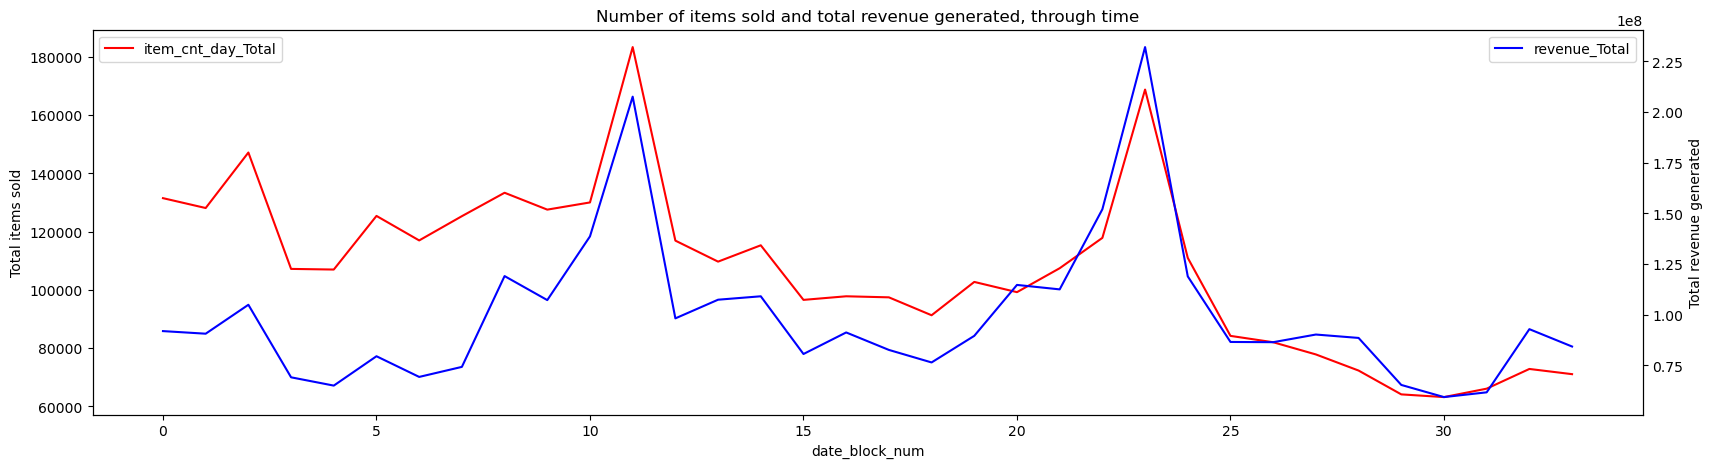

In [18]:
# Create a plot to see (monthly) number of items sold and revenue generated through time

fig = plt.figure(figsize=(20,5))  #Create matplotlib figure

ax = fig.add_subplot(111)  #Create matplotlib axes
ax2 = ax.twinx()  #Create another axes that shares the same x-axis as ax.

temp_df = item_cnt_day_revenue_price_df[['date_block_num', 'item_cnt_day_Total']].groupby('date_block_num').sum()
temp_df.plot(color='red', ax=ax, label='Total items sold through time')

temp_df = item_cnt_day_revenue_price_df[['date_block_num', 'revenue_Total']].groupby('date_block_num').sum()
temp_df.plot(color='blue', ax=ax2, label='Total revenue generated through time')

ax.set_ylabel('Total items sold')
ax2.set_ylabel('Total revenue generated')

plt.title('Number of items sold and total revenue generated, through time')
ax.set_xlabel('date_block_num')
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

__What we observe in the plot above:__  
- Both the number of products sold and the revenue generated are declining during the 34 months contained in the data.
- There is a significant seasonality appearing in the data around months 11-12 and 23-24. These months correspond to November and December of the 1st and 2nd year respectively, so the sales increase a lot due to the __Christmas__ period.

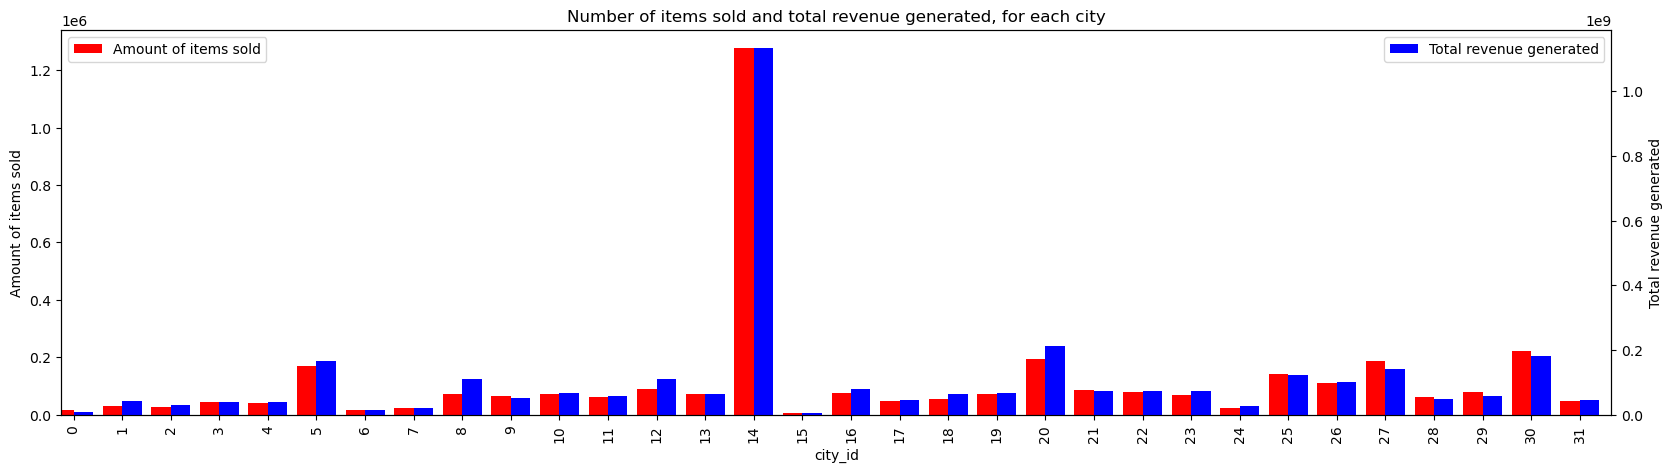

In [19]:
# Create a plot to see how many items (of any item_id) have been sold in each city, along with the total revenue generated

temp_df = complete_df[['city_id','item_cnt_day','revenue']]

temp_df = temp_df.groupby('city_id').agg({'item_cnt_day':sum, 'revenue':sum})
temp_df.reset_index(inplace=True)

fig = plt.figure(figsize=(20,5))  #Create matplotlib figure

ax = fig.add_subplot(111)  #Create matplotlib axes
ax2 = ax.twinx()  #Create another axes that shares the same x-axis as ax.

temp_df.item_cnt_day.plot(kind='bar', color='red', ax=ax, width=0.4, position=1, label='Amount of items sold')
temp_df.revenue.plot(kind='bar', color='blue', ax=ax2, width=0.4, position=0, label='Total revenue generated')

ax.set_ylabel('Amount of items sold')
ax2.set_ylabel('Total revenue generated')

plt.title('Number of items sold and total revenue generated, for each city')
ax.set_xlabel('city_id')
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

__What we observe in the plot (bar chart) above:__  
- There is a lot of variation among the cities: Some are doing much better (items sold, revenue generated) than others.
- From the total of 32 cities, only 1 has sold more than 300,000 items and only 2 have sold more than 200,000 items.  
- There is 1 city that is doing by far better than the rest: city with id #14 has sold 1,276,376 items during the 34 months of interest.

### Data Preparation 2 - Sanity Checks and Fixes

In [20]:
#[1] Replace a price which is <0 with the average price for the respective shop / item / month

len_1 = len(complete_df[complete_df['item_price']<=0])
print('Check1: Number of transactions (rows) where item_price<0: ',len_1)

if len_1 == 1:

    my_shop_id = complete_df[complete_df['item_price']<=0].shop_id.values[0]
    my_item_id = complete_df[complete_df['item_price']<=0].item_id.values[0]
    my_month = complete_df[complete_df['item_price']<=0].date_block_num.values[0]
    new_val_1 = complete_df[(complete_df['shop_id']==my_shop_id)&(complete_df['item_id']==my_item_id)&(
                        complete_df['date_block_num']==my_month)&(complete_df['item_price']>0)].item_price.mean() 

    complete_df.loc[complete_df.item_price<0, 'item_price'] = new_val_1
    complete_df['revenue'] = complete_df['item_price'] * complete_df['item_cnt_day']
    
#[2] Check if there are any NaN values in the data

len_2 = complete_df.isna().sum().sum()
print('Check2: Number of NaN values in the data: ',len_2)

Check1: Number of transactions (rows) where item_price<0:  1
Check2: Number of NaN values in the data:  0


Create a dataframe called "__complete_df_monthly__" that contains data grouped per month. We will use this later in the notebook.

In [21]:
complete_df_monthly = complete_df.groupby(['date_block_num','shop_id','item_id','item_name','item_category_id',
                                           'item_category_name','type_name','type_id','shop_name','city_name','city_id',
                                           'month','year']).agg({'item_cnt_day': ['sum'], 'revenue': ['sum']})
complete_df_monthly.columns=['item_cnt_month_ORIG','revenue_month_ORIG']
complete_df_monthly.reset_index(inplace=True)
complete_df_monthly.head()

,date_block_num,shop_id,item_id,item_name,item_category_id,item_category_name,type_name,type_id,shop_name,city_name,city_id,month,year,item_cnt_month_ORIG,revenue_month_ORIG
0,0,0,32,Item 32,40,Item Category 40,Type 11,11,Shop 0,City 0,0,1,2013,6.0,1326.0
1,0,0,33,Item 33,37,Item Category 37,Type 11,11,Shop 0,City 0,0,1,2013,3.0,1041.0
2,0,0,35,Item 35,40,Item Category 40,Type 11,11,Shop 0,City 0,0,1,2013,1.0,247.0
3,0,0,43,Item 43,40,Item Category 40,Type 11,11,Shop 0,City 0,0,1,2013,1.0,221.0
4,0,0,51,Item 51,57,Item Category 57,Type 13,13,Shop 0,City 0,0,1,2013,2.0,257.0


In [22]:
complete_df_monthly.shape

(1609124, 15)

### Feature Engineering

In this section we will create new data features that will enrich our dataset and better describe it, capturing valuable information and patterns. Mainly we will focus on average monthly sales among different combinations of existing features, such as items, shops, categories, cities, etc.

In [23]:
#[1] For each combination of (date_block_num, shop_id, item_id) calculate the monthly sales
temp_df = complete_df.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
temp_df.columns = ['item_cnt_month']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','shop_id','item_id'])

#[2] For each month calculate the average sales among all items
temp_df = complete_df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num'])

#[3] For each combination of (month, item_id) calculate the average sales among all items of that specific item_id
temp_df = complete_df.groupby(['date_block_num','item_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_item_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','item_id'])

#[4] For each combination of (month, shop_id) calculate the average sales among all items of that specific shop_id
temp_df = complete_df.groupby(['date_block_num','shop_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_shop_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','shop_id'])

#[5] For each combination of (month, item_category_id) calculate the average sales among all items of that specific item_category_id
temp_df = complete_df.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_cat_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','item_category_id'])

#[6] For each combination of (month, type_id) calculate the average sales among all items of that specific type_id
temp_df = complete_df.groupby(['date_block_num','type_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_type_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','type_id'])

#[7] For each combination of (month, shop_id, item_category_id) calculate the average sales among all items of that combination
temp_df = complete_df.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_shop_cat_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','shop_id','item_category_id'])

#[8] For each combination of (month, shop_id, type_id) calculate the average sales among all items of that combination
temp_df = complete_df.groupby(['date_block_num','shop_id','type_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_shop_type_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','shop_id','type_id'])

#[9] For each combination of (month, city_id) calculate the average sales among all items of that specific city
temp_df = complete_df.groupby(['date_block_num','city_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_city_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','city_id'])

#[10] For each combination of (month, item_id, city_id) calculate the average sales among all items of that combination
temp_df = complete_df.groupby(['date_block_num','item_id','city_id']).agg({'item_cnt_month': ['mean']})
temp_df.columns = ['avg_monthly_item_city_sales']
temp_df.reset_index(inplace=True)

complete_df = pd.merge(complete_df, temp_df, how='left', on=['date_block_num','item_id','city_id'])

#[11] For each combination of (month, item_id) calculate the percent difference of average price from the overall average item_id price
temp_df1 = complete_df.groupby(['item_id']).agg({'item_price': ['mean']})
temp_df1.columns = ['avg_item_price']
temp_df1.reset_index(inplace=True)

temp_df2 = complete_df.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
temp_df2.columns = ['avg_monthly_item_price']
temp_df2.reset_index(inplace=True)

temp_df3 = pd.merge(temp_df2, temp_df1, how='left', on=['item_id'])
temp_df3['monthly_delta_item_price'] = (temp_df3['avg_monthly_item_price'] - temp_df3['avg_item_price']) / temp_df3['avg_item_price']
temp_df3 = temp_df3[['date_block_num', 'item_id', 'monthly_delta_item_price']]

complete_df = pd.merge(complete_df, temp_df3, how='left', on=['date_block_num','item_id'])

#[12] For each combination of (month, shop_id) calculate the percent difference of average revenue from the overall average shop_id revenue
temp_df1 = complete_df.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
temp_df1.columns = ['monthly_shop_revenue']
temp_df1.reset_index(inplace=True)

temp_df2 = temp_df1.groupby(['shop_id']).agg({'monthly_shop_revenue': ['mean']})
temp_df2.columns = ['avg_monthly_shop_revenue']
temp_df2.reset_index(inplace=True)

temp_df3 = pd.merge(temp_df1, temp_df2, how='left', on=['shop_id'])
temp_df3['monthly_delta_shop_revenue'] = (temp_df3['monthly_shop_revenue'] - temp_df3['avg_monthly_shop_revenue']) / temp_df3['avg_monthly_shop_revenue']
temp_df3 = temp_df3[['date_block_num', 'shop_id', 'monthly_delta_shop_revenue']]

complete_df = pd.merge(complete_df, temp_df3, how='left', on=['date_block_num','shop_id'])

### Finalize Data Matrix and Features

In this section we will finalize the data matrix, creating some lag features (e.g. the feature value for 1 month ago, 2 months ago, etc), and we will drop some columns that will not be used for machine learning model training. This will provide as the final data input for our models.

In [24]:
# Drop from complete_df_monthly the columns that are not needed
complete_df_monthly_final = complete_df_monthly.drop(['item_name','item_category_name','type_name','shop_name','city_name','month','year',
                                     'item_cnt_month_ORIG','revenue_month_ORIG'], axis=1)

In [25]:
# Misc Functions

def update_complete_df_monthly(complete_df, complete_df_monthly_final, col):
    temp_df = complete_df[['date_block_num', 'shop_id', 'item_id', col]]
    temp_df.drop_duplicates(inplace=True)
    complete_df_monthly_final = pd.merge(complete_df_monthly_final,temp_df,how='left',on=['date_block_num','shop_id','item_id'])
    return complete_df_monthly_final    

def feature_lag(df, lags_list, col):
    temp_df = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags_list:
        shifted_df = temp_df.copy()
        shifted_df.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted_df['date_block_num'] += i
        df = pd.merge(df, shifted_df, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [26]:
#1 Create lag features for "item_cnt_month"  [1,2,3,6,12 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'item_cnt_month')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1,2,3,6,12], 'item_cnt_month')

#2 Create lag features for "avg_monthly_sales"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'avg_monthly_sales')

#3 Create lag features for "avg_monthly_item_sales"  [1,2,3,6,12 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_item_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1,2,3,6,12], 'avg_monthly_item_sales')

#4 Create lag features for "avg_monthly_shop_sales"  [1,2,3,6,12 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_shop_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1,2,3,6,12], 'avg_monthly_shop_sales')

#5 Create lag features for "avg_monthly_cat_sales"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_cat_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'avg_monthly_cat_sales')

#6 Create lag features for "avg_monthly_type_sales"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_type_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'avg_monthly_type_sales')

#7 Create lag features for "avg_monthly_shop_cat_sales"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_shop_cat_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'avg_monthly_shop_cat_sales')

#9 Create lag features for "avg_monthly_city_sales"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_city_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'avg_monthly_city_sales')

#10 Create lag features for "avg_monthly_item_city_sales"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'avg_monthly_item_city_sales')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'avg_monthly_item_city_sales')

#11 Create lag features for "monthly_delta_item_price"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'monthly_delta_item_price')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'monthly_delta_item_price')

#12 Create lag features for "monthly_delta_shop_revenue"  [1 months]
complete_df_monthly_final = update_complete_df_monthly(complete_df, complete_df_monthly_final, 'monthly_delta_shop_revenue')
complete_df_monthly_final = feature_lag(complete_df_monthly_final, [1], 'monthly_delta_shop_revenue')

C:\Users\SESA671988\AppData\Local\Temp\ipykernel_7180\1799475052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\SESA671988\AppData\Local\Temp\ipykernel_7180\1799475052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\SESA671988\AppData\Local\Temp\ipykernel_7180\1799475052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop

In [27]:
# Drop from complete_df_monthly_final the columns that are not needed
complete_df_monthly_final = complete_df_monthly_final.drop(['avg_monthly_sales', 'avg_monthly_item_sales', 
                                'avg_monthly_shop_sales', 'avg_monthly_cat_sales', 'avg_monthly_type_sales',
                                'avg_monthly_shop_cat_sales', 'avg_monthly_city_sales', 'avg_monthly_item_city_sales', 
                                'monthly_delta_item_price', 'monthly_delta_shop_revenue'], axis=1)

In [28]:
complete_df_monthly_final.tail(2)

,date_block_num,shop_id,item_id,item_category_id,type_id,city_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,avg_monthly_shop_sales_lag_3,avg_monthly_shop_sales_lag_6,avg_monthly_shop_sales_lag_12,avg_monthly_cat_sales_lag_1,avg_monthly_type_sales_lag_1,avg_monthly_shop_cat_sales_lag_1,avg_monthly_city_sales_lag_1,avg_monthly_item_city_sales_lag_1,monthly_delta_item_price_lag_1,monthly_delta_shop_revenue_lag_1
1609122,33,59,22100,42,12,31,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,5.939502,4.674242,3.25,3.628535,1.0,-0.004251,-0.175418
1609123,33,59,22102,42,12,31,1.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
complete_df_monthly.tail(2)

,date_block_num,shop_id,item_id,item_name,item_category_id,item_category_name,type_name,type_id,shop_name,city_name,city_id,month,year,item_cnt_month_ORIG,revenue_month_ORIG
1609122,33,59,22100,Item 22100,42,Item Category 42,Type 12,12,Shop 59,City 31,31,10,2015,1.0,629.0
1609123,33,59,22102,Item 22102,42,Item Category 42,Type 12,12,Shop 59,City 31,31,10,2015,1.0,1250.0


In [30]:
complete_df.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,type_name,...,avg_monthly_item_sales,avg_monthly_shop_sales,avg_monthly_cat_sales,avg_monthly_type_sales,avg_monthly_shop_cat_sales,avg_monthly_shop_type_sales,avg_monthly_city_sales,avg_monthly_item_city_sales,monthly_delta_item_price,monthly_delta_shop_revenue
2935847,2015-10-22,33,25,7440,299.0,1.0,Item 7440,57,Item Category 57,Type 13,...,1.000000,9.918153,1.626703,1.973373,1.491803,3.165205,8.179238,1.000000,0.025194,0.198974
2935848,2015-10-03,33,25,7460,299.0,1.0,Item 7460,55,Item Category 55,Type 13,...,1.615385,9.918153,2.050009,1.973373,3.852697,3.165205,8.179238,2.142857,0.000342,0.198974


In [31]:
print(complete_df_monthly_final.shape, complete_df_monthly.shape, complete_df.shape)

(1609124, 30) (1609124, 15) (2935849, 29)


In [32]:
# Store the processed dataframes into pickle files, so that we do not have to rerun this script

complete_df_monthly_final.to_pickle(r'complete_df_monthly_final.pkl')
complete_df.to_pickle(r'complete_df.pkl')